# Single Path One-Shot Neural Architecture Search using Random Search

### Make everything a bit faster

Your task is to implement SPOS + Random Search to find the optimal ResNet-18-like architecture
for image classification on CIFAR-10 dataset.

### Proposed search space
The same search space as in the lecture, but without kernel size search.
This means that each search block should only have 3 operations.

### Latency awareness
While searching, you should implement hard constraint on model latency. As a proxy for
latency, use the number of MACs. The baseline ResNet-18 has 37M MACs for images of size 32x32.
The final selected architecture should have at most 30M MACs.
You can find an example computation for the number of MACs in this notebook.

### How to complete the task
Plan for your experiments:
1. Train baseline ResNet-18 model.  **(2 pts)**
2. Finalize supernet code. **(15 pts)**
3. Train supernet with the same hyperparameters except the number of epochs. You should increase
   it by a factor of 3-6. Save supernet weights.  **(10 pts)**
4. Write implementation for Random Search.  **(10 pts)**
5. Run it for 100-1000 iterations by measuring accuracies of models from the supernet.
   Keep track of each model accuracy and latency.  **(5 pts)**
6. Train the best architecture from scratch. For this, you can build the whole supernet, and
   select this architecture for all the forward passes of the training.  **(6 pts)**
7. Compare with the model from step 1. Does your model have a better accuracy?  **(2 pts)**

### Code structure

Main.ipynb - Learn your neural networks here.

resnet.py - ResNet-18 implementation from torchvision, simplified for this project.

supernet.py - Unfinished Supernet implementation.

cifar10.py - Transforms for CIFAR-10 training.


# Analysis notebook

## Setup

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

### Read saved data

In [2]:
with open('random_search_500_models_supernet_base_120.json', 'r') as f:
    search_data = json.load(f)

In [3]:
accuracy = np.array(search_data['accuracy'])
loss = np.array(search_data['loss'])
macs = np.array(search_data['macs'])
params = np.array(search_data['params'])
architectures = search_data['arch']

### Define MAC limit as per task constraints

In [4]:
target_latency = 30 * 1e6

suitable_arch_indices = (macs <= target_latency)

### Show all evaluations

In [5]:
for i in np.argsort(accuracy)[::-1]:
    print(f'{accuracy[i]:.2%} {macs[i]:.2f} {architectures[i]}')

85.77% 47275008.00 [1, 2, 2, 1, 2, 1, 0, 1]
85.61% 44321792.00 [1, 2, 2, 0, 2, 1, 1, 0]
85.52% 56129536.00 [1, 2, 2, 2, 1, 0, 2, 2]
85.48% 50242560.00 [2, 2, 2, 2, 1, 0, 1, 0]
85.45% 55553024.00 [2, 2, 2, 2, 1, 0, 0, 2]
85.45% 46673920.00 [2, 0, 2, 0, 2, 0, 1, 2]
85.45% 56718336.00 [1, 2, 2, 1, 2, 2, 0, 2]
85.44% 49041408.00 [1, 2, 2, 0, 2, 0, 1, 2]
85.43% 44906496.00 [0, 2, 2, 0, 2, 2, 0, 0]
85.42% 43737088.00 [1, 2, 2, 2, 1, 0, 0, 0]
85.36% 52578304.00 [0, 2, 2, 1, 1, 2, 1, 2]
85.36% 62637056.00 [2, 2, 2, 2, 1, 2, 0, 2]
85.35% 52599808.00 [2, 2, 2, 1, 2, 0, 2, 0]
85.35% 49050624.00 [1, 2, 2, 2, 2, 0, 1, 0]
85.35% 51993600.00 [0, 2, 2, 2, 2, 0, 0, 2]
85.34% 59675648.00 [1, 2, 2, 2, 2, 2, 2, 0]
85.32% 56733696.00 [2, 2, 2, 2, 0, 1, 2, 1]
85.32% 47864832.00 [1, 2, 2, 1, 1, 2, 1, 0]
85.31% 39590912.00 [1, 1, 2, 2, 0, 0, 0, 1]
85.30% 52597760.00 [2, 2, 2, 0, 2, 1, 2, 0]
85.29% 40183808.00 [2, 0, 2, 0, 2, 1, 0, 0]
85.27% 41362432.00 [1, 1, 2, 2, 0, 1, 1, 0]
85.27% 51984384.00 [1, 1, 2, 2, 

### Show value distributions

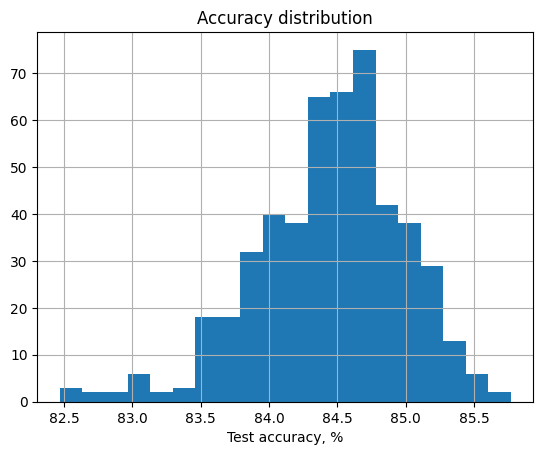

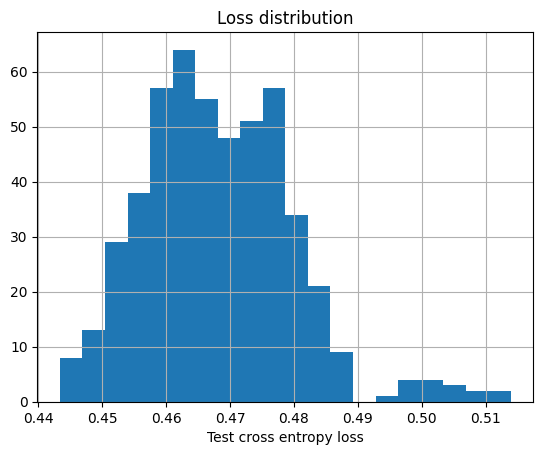

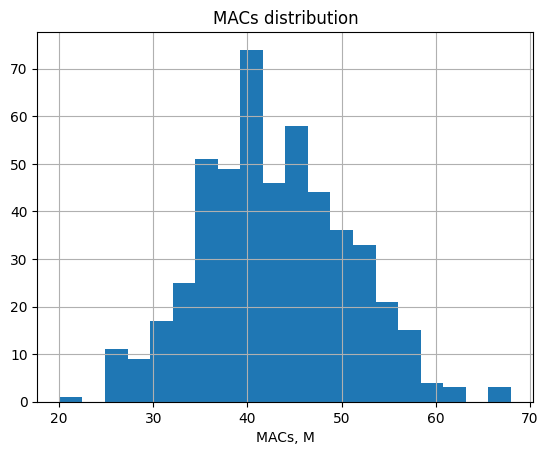

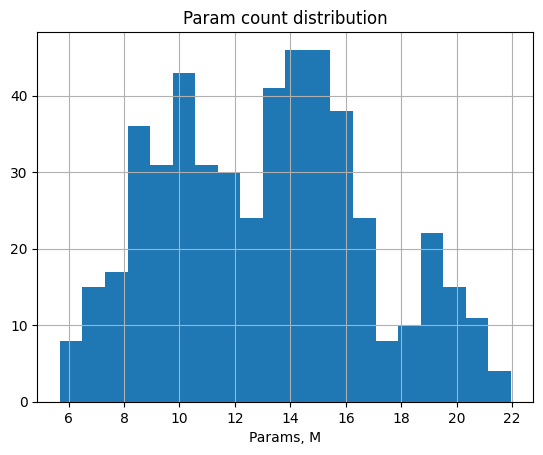

In [6]:
plt.title('Accuracy distribution')
plt.hist(accuracy * 100, bins=20)
plt.xlabel('Test accuracy, %')
plt.grid()
plt.show()

plt.title('Loss distribution')
plt.hist(loss, bins=20)
plt.xlabel('Test cross entropy loss')
plt.grid()
plt.show()

plt.title('MACs distribution')
plt.hist(macs / 1e6, bins=20)
plt.xlabel('MACs, M')
plt.grid()
plt.show()

plt.title('Param count distribution')
plt.hist(params / 1e6, bins=20)
plt.xlabel('Params, M')
plt.grid()
plt.show()

### Find the best architecture

In [7]:
# Keep accuracy if arch satisfies MACs contraint and use 0 otherwise.
best_arch_index = (suitable_arch_indices * accuracy).argmax()

best_arch = architectures[best_arch_index]

print(f'Best architecture: {best_arch}')
print(
    f'MACs={(macs[best_arch_index] / 1e6):.2f}M, '
    f'params={params[best_arch_index] / 1e6:.2f}M, '
    f'accuracy={accuracy[best_arch_index]:.2%}, '
    f'loss={loss[best_arch_index]:.4f}'
)
print()

print(f'Mean MACs: {macs.mean() / 1e6:.2f}M')
print(f'Mean test accuracy: {accuracy.mean():.2%}')

Best architecture: [0, 1, 2, 0, 0, 0, 1, 0]
MACs=29.54M, params=7.83M, accuracy=84.73%, loss=0.4591

Mean MACs: 42.92M
Mean test accuracy: 84.45%


### Final analysis

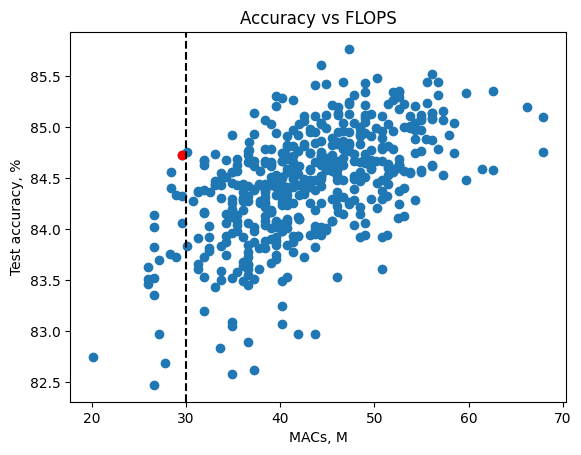

Total number of architectures satisfying latency contraint: 21 (4.2%)


In [8]:
plt.title('Accuracy vs FLOPS')
plt.axvline(target_latency / 1e6, c='k', linestyle='--')
plt.scatter(macs / 1e6, accuracy * 100)
plt.scatter([macs[best_arch_index] / 1e6], accuracy[best_arch_index] * 100, c='r')
plt.xlabel('MACs, M')
plt.ylabel('Test accuracy, %')
plt.show()

print(
    f'Total number of architectures satisfying latency contraint: {suitable_arch_indices.sum()} '
    f'({suitable_arch_indices.sum() / len(macs):.1%})'
)

## Observations from the analysis

1. Search space is not so good for our task. A lot of students actually noticed that only a small number of architectures from the search space satisfy latency (MACs) constraint.
2. Accuracy is correlated with latency.
3. The best architecture using SPOS & Random Search is [0, 1, 2, 0, 0, 0, 1, 0] with 29.5M MACs and 84.7% test accuracy.

## In conclusion, search space should be improved